# Specific Other thigns to Test

1. Viz discounts in train

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
DIRECTORY = './data/'
calendar = pd.read_csv(DIRECTORY + 'calendar.csv', parse_dates=['date'])
inventory = pd.read_csv(DIRECTORY + 'inventory.csv')
test = pd.read_csv(DIRECTORY + 'sales_test.csv', parse_dates=['date'])
train = pd.read_csv(DIRECTORY + 'sales_train.csv', parse_dates=['date'])
solution = pd.read_csv(DIRECTORY + 'solution.csv')
test_weights = pd.read_csv(DIRECTORY + 'test_weights.csv')

In [3]:
discount_cols = [col for col in train.columns if 'discount' in col]
train[discount_cols].describe()

,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,type_5_discount,type_6_discount
count,4.007419e+06,4.007419e+06,4.007419e+06,4.007419e+06,4.007419e+06,4.007419e+06,4.007419e+06
mean,8.518626e-03,1.240899e-04,1.163193e-03,5.452819e-06,5.680178e-03,4.049705e-04,1.045480e-02
std,5.147027e-02,5.142815e-03,1.879977e-02,8.922436e-04,2.892965e-02,9.199913e-03,5.545035e-02
min,-2.094930e+01,0.000000e+00,0.000000e+00,0.000000e+00,-4.712000e-02,0.000000e+00,-8.014900e-01
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,9.916400e-01,5.000000e-01,7.637200e-01,2.506300e-01,4.529000e-01,6.691400e-01,9.000500e-01


2. How do different factors affect sales (sell price, availability, discounts)

In [4]:
inventory['name_first'] = inventory['name'].str.split('_').str[0]
train = train.sort_values(by='date')
train = train.merge(inventory, on='unique_id', how='left')

In [5]:
train[train['name_first'] == 'Blueberry']['product_unique_id'].unique()

array([1614, 2602,  918, 2470,  799, 1232,  699,   16,  818, 1506,  283,
       1635, 1609, 1340,  940, 1282, 1866,  782,  547,  850,  630, 1807,
       1720,    1, 1589, 2181,  890, 2166,  489, 1263, 2332, 2007, 1881,
          9, 1109, 2257])

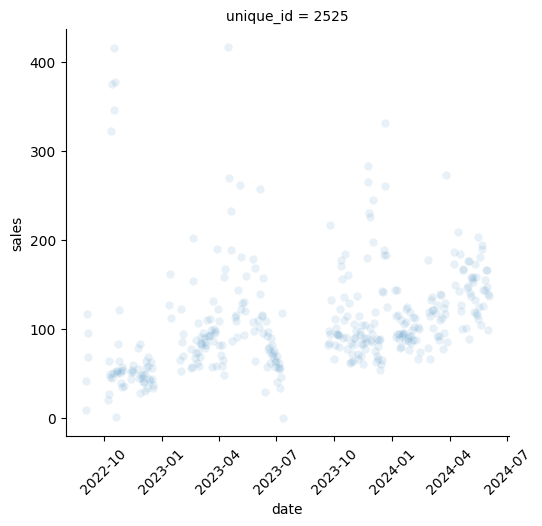

In [6]:
g = sns.relplot(
    data=train[train['product_unique_id'] == 1263], 
    x='date', 
    y='sales', 
    alpha=0.1, 
    col='unique_id', 
    col_wrap=3
)

# Rotate x-axis tick labels
for ax in g.axes.flat:
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.show()

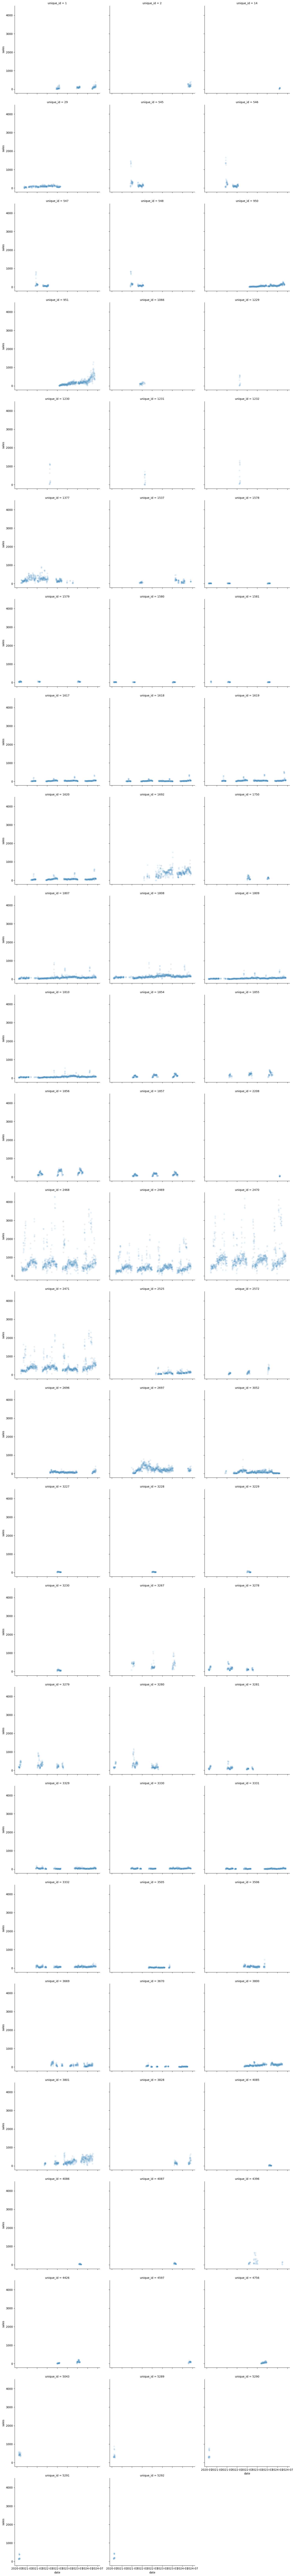

In [7]:
sns.relplot(train[train['name_first'] == 'Blueberry'], x='date', y='sales', alpha=0.1, col='unique_id', col_wrap=3)
plt.show()

In [8]:
train[train[''] == 1].sort_values(by='date')

KeyError: ''

In [26]:
inventory[inventory['unique_id'] == 1]

,unique_id,product_unique_id,name,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,warehouse
3849,1,1,Blueberry_0,Fruit and vegetable,Fruit and vegetable_L2_1,Fruit and vegetable_L3_1,Fruit and vegetable_L4_1,Frankfurt_1


3. How many "gaps" does the average product have?

How many consecutive ranges do they have with rows

In [56]:
# How many unique ids are fully contiguous
day_range = (train.groupby('unique_id')['date'].max() - train.groupby('unique_id')['date'].min()).dt.days
day_count = train.groupby('unique_id')['date'].count()

(day_range == day_count).value_counts()

date
False    5274
True      116
Name: count, dtype: int64

In [82]:
# How may times is the previous day not the day before

train['prev_sale_day'] = train.groupby('unique_id')['date'].shift(1)

In [83]:
train['is_noncontinuous'] = train['date'] > (train['prev_sale_day'] + pd.Timedelta('7D'))

In [132]:
count_noncontinuous = train.groupby('unique_id')['is_noncontinuous'].sum()
count_noncontinuous.describe()

count    5390.000000
mean        1.757328
std         2.674755
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max        43.000000
Name: is_noncontinuous, dtype: float64

<Figure size 640x480 with 0 Axes>

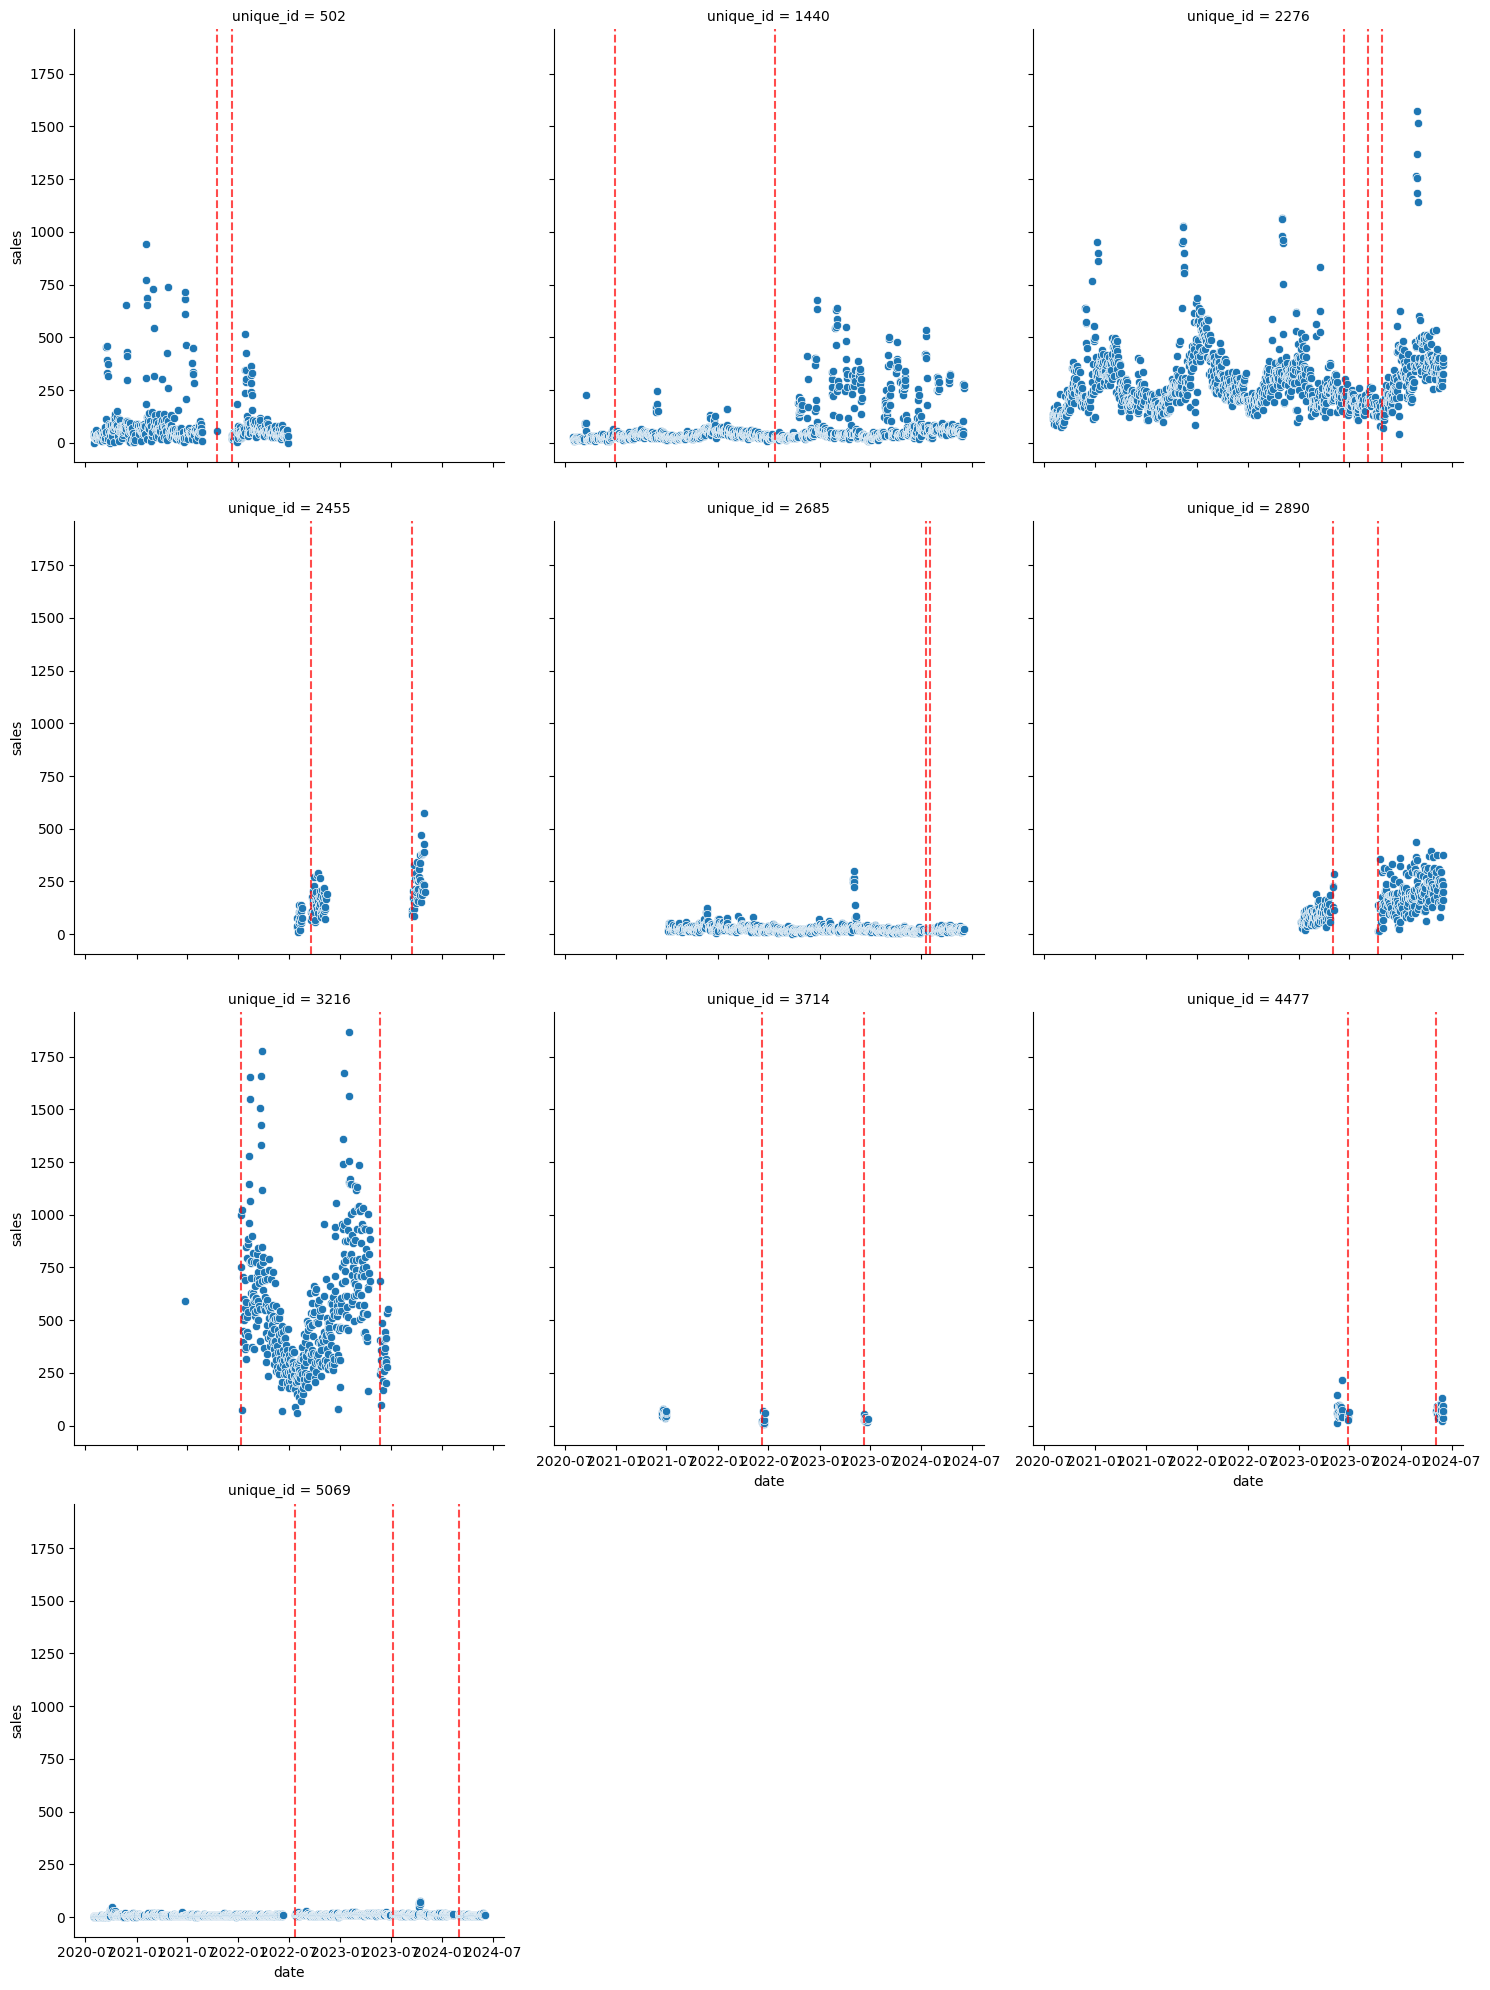

In [131]:
chosen = count_noncontinuous[count_noncontinuous > 1].sample(10).index
chosen_train = train[train['unique_id'].isin(chosen)]
chosen = chosen_train['unique_id'].unique()

plt.clf()
g = sns.relplot(chosen_train, x='date', y='sales', col='unique_id', col_wrap=3, kind='scatter')
# Loop through each subplot and add vertical lines where 'indicator' is True
for unique_id, ax in g.axes_dict.items():
    subset = train[(train['unique_id'] == unique_id) & (train['is_noncontinuous'] == True)]
    
    for date in subset['date']:
        ax.axvline(x=date, color='red', linestyle='--', alpha=0.7)

plt.show();

In [93]:
train[train['unique_id'] == 186]

,unique_id,date,warehouse_x,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,...,name,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,warehouse_y,name_first,prev_sale_day,is_continuous,is_noncontinuous
1374239,186,2022-03-29,Budapest_1,5643.0,256.92,491.27,0.93,0.00000,0.0,0.0,...,Banana_2,Fruit and vegetable,Fruit and vegetable_L2_0,Fruit and vegetable_L3_52,Fruit and vegetable_L4_1,Budapest_1,Banana,NaT,False,False
1375267,186,2022-03-30,Budapest_1,5900.0,282.16,491.27,0.67,0.00000,0.0,0.0,...,Banana_2,Fruit and vegetable,Fruit and vegetable_L2_0,Fruit and vegetable_L3_52,Fruit and vegetable_L4_1,Budapest_1,Banana,2022-03-29,True,False
1381895,186,2022-04-01,Budapest_1,5997.0,4.69,491.26,0.01,0.00000,0.0,0.0,...,Banana_2,Fruit and vegetable,Fruit and vegetable_L2_0,Fruit and vegetable_L3_52,Fruit and vegetable_L4_1,Budapest_1,Banana,2022-03-30,False,False
1384574,186,2022-04-02,Budapest_1,5302.0,397.05,491.26,0.88,0.00000,0.0,0.0,...,Banana_2,Fruit and vegetable,Fruit and vegetable_L2_0,Fruit and vegetable_L3_52,Fruit and vegetable_L4_1,Budapest_1,Banana,2022-04-01,True,False
1387236,186,2022-04-03,Budapest_1,4854.0,282.86,491.26,0.56,0.00000,0.0,0.0,...,Banana_2,Fruit and vegetable,Fruit and vegetable_L2_0,Fruit and vegetable_L3_52,Fruit and vegetable_L4_1,Budapest_1,Banana,2022-04-02,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1596601,186,2022-06-14,Budapest_1,5343.0,435.68,562.23,0.96,0.30538,0.0,0.0,...,Banana_2,Fruit and vegetable,Fruit and vegetable_L2_0,Fruit and vegetable_L3_52,Fruit and vegetable_L4_1,Budapest_1,Banana,2022-06-13,True,False
1604612,186,2022-06-16,Budapest_1,5786.0,134.67,561.53,0.96,0.00000,0.0,0.0,...,Banana_2,Fruit and vegetable,Fruit and vegetable_L2_0,Fruit and vegetable_L3_52,Fruit and vegetable_L4_1,Budapest_1,Banana,2022-06-14,False,False
1606448,186,2022-06-17,Budapest_1,5746.0,182.91,561.53,1.00,0.00000,0.0,0.0,...,Banana_2,Fruit and vegetable,Fruit and vegetable_L2_0,Fruit and vegetable_L3_52,Fruit and vegetable_L4_1,Budapest_1,Banana,2022-06-16,True,False
1609538,186,2022-06-18,Budapest_1,4978.0,111.41,561.53,1.00,0.00000,0.0,0.0,...,Banana_2,Fruit and vegetable,Fruit and vegetable_L2_0,Fruit and vegetable_L3_52,Fruit and vegetable_L4_1,Budapest_1,Banana,2022-06-17,True,False
